<a href="https://colab.research.google.com/github/jkranyak/project_3/blob/main/project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr 11 23:27:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install tensorflow
!pip install isic-cli
!pip install isic-cli
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.1 MB/s eta 0:00:00
If you have been granted special permissions, logging in with `isic user login` might return more data.

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ ID  ┃ Name                                          ┃ Public ┃ Pinned ┃ Locked ┃ DOI             ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 249 │ BCN20000                                      │ True   │ False  │ False  │ None            │
│ 61  │ Challenge 2016: Test                          │ True   │ True   │ True   │ None            │
│ 74  │ Challenge 2016: Training                      │ True   │ 

In [ ]:
! isic user login

visit the following url in a browser:
https://api.isic-archive.com/oauth/authorize?response_type=code&client_id=RpCzc4hFjv5gOJdM2DM2nBdokOviOh5ne63Tpn7Q&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=kmGwfoz4avuEVKECGVadANUQxs5Q1D&code_challenge=wNZcxvZUgcaMlKSwsGU8BhZt_yqDd7JTA6dVzC5JrW0&code_challenge_method=S256
enter the code shown in your browser: 8feAFBcQvyoeNl9BDi5Kjx00Or6x3D
Success!


In [4]:
!isic collection list

If you have been granted special permissions, logging in with `isic user login` might return more data.

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ ID  ┃ Name                                          ┃ Public ┃ Pinned ┃ Locked ┃ DOI             ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 249 │ BCN20000                                      │ True   │ False  │ False  │ None            │
│ 61  │ Challenge 2016: Test                          │ True   │ True   │ True   │ None            │
│ 74  │ Challenge 2016: Training                      │ True   │ True   │ True   │ None            │
│ 69  │ Challenge 2017: Test                          │ True   │ True   │ True   │ None            │
│ 60  │ Challenge 2017: Training                      │ True   │ True   │ True   │ None            │
│ 71  │ Challenge 2017: Validation                    │ True   │ True   │ True   │ None

Step 2: Query the Dataset
Endpoints: Use the API endpoints to query the dataset. Common operations include listing available images, retrieving image metadata, and downloading images.
Filtering: Utilize query parameters to filter the dataset based on your criteria, such as diagnosis, image type, or other metadata.

In [5]:
import requests
import os
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import drive
from PIL import Image

In [6]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


Comment out if already running

In [11]:
# Specify the current path of kaggle.json file
current_path = '/content/kaggle.json'

# Desired path where the Kaggle API expects the kaggle.json file
desired_path = '/root/.kaggle/kaggle.json'

if os.path.exists(current_path):
    os.makedirs(os.path.dirname(desired_path), exist_ok=True)
    os.rename(current_path, desired_path)

    # Set the file's permissions to avoid a permissions error
    os.chmod(desired_path, 0o600)
else:
    print(f"Error: '{current_path}' does not exist. Please upload the file.")



find the data set on kaggle

Comment out if running and already have downloaded images

In [12]:
!kaggle datasets download -d andrewmvd/isic-2019


100% 9.10G/9.10G [05:08<00:00, 39.6MB/s]
100% 9.10G/9.10G [05:08<00:00, 31.7MB/s]


In [13]:
!unzip -q isic-2019.zip


Step 1: Data Preparation and Preprocessing
DICOM Images

DICOM Handling: Use pydicom to read DICOM files, which contain both the images and embedded metadata. For each DICOM file, extract the image data for preprocessing and the metadata for analysis.
Image Preprocessing: Since DICOM images might not be uniformly sized, you may need to resize them to a standard size (e.g., 1024x1024) to match the TFRecord images, normalize pixel values, and potentially augment the data to improve model robustness.
JPEG and TFRecord Images

JPEG Handling: Directly read and preprocess (resize if necessary, normalize, augment).
TFRecord Handling: Extract and preprocess. TFRecord files are already uniformly sized, which simplifies preprocessing.
Metadata

CSV Metadata: Load the metadata from CSV files. Clean and preprocess this data, which involves handling missing values, normalizing or scaling numerical features, and encoding categorical features.



Load the metadata

and

Explore the Metadata CSV: Load the metadata.csv files for training, test, and validation sets to understand the structure and types of data available. This step is crucial for preprocessing and feature selection.

In [14]:
# Load the metadata
metadata = pd.read_csv('/content/ISIC_2019_Training_Metadata.csv')

# Display the first few rows of each DataFrame
metadata.head()


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [15]:
ground_truth = pd.read_csv('/content/ISIC_2019_Training_GroundTruth.csv')
ground_truth

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Load the CSV files
ground_truth = pd.read_csv('/content/ISIC_2019_Training_GroundTruth.csv')
metadata = pd.read_csv('/content/ISIC_2019_Training_Metadata.csv')

image_dir = '/content/ISIC_2019_Training_Images'
ground_truth['image_path'] = ground_truth['image'].apply(lambda x: os.path.join(image_dir, x + '.jpg'))

# Merge the ground_truth with metadata if necessary
full_metadata = pd.merge(ground_truth, metadata, on='image', how='left')  # Adjust 'on' parameter as needed
full_metadata

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_path,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,55.0,anterior torso,NaN,female
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,30.0,anterior torso,NaN,female
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,60.0,upper extremity,NaN,female
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,30.0,upper extremity,NaN,male
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,80.0,posterior torso,NaN,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007325...,55.0,palms/soles,BCN_0002083,female


In [17]:
# Display the image paths for the first few entries
print(full_metadata['image_path'].head())


0    /content/ISIC_2019_Training_Images/ISIC_000000...
1    /content/ISIC_2019_Training_Images/ISIC_000000...
2    /content/ISIC_2019_Training_Images/ISIC_000000...
3    /content/ISIC_2019_Training_Images/ISIC_000000...
4    /content/ISIC_2019_Training_Images/ISIC_000000...
Name: image_path, dtype: object


In [18]:
# Correct the base path in 'image_path' column
correct_base_path = "/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

full_metadata['image_path'] = full_metadata['image'].apply(lambda x: f"{correct_base_path}/{x}.jpg")

# Verify the correction by printing the first few entries again
print(full_metadata['image_path'].head())


0    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
Name: image_path, dtype: object


In [19]:
full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   MEL                  25331 non-null  float64
 2   NV                   25331 non-null  float64
 3   BCC                  25331 non-null  float64
 4   AK                   25331 non-null  float64
 5   BKL                  25331 non-null  float64
 6   DF                   25331 non-null  float64
 7   VASC                 25331 non-null  float64
 8   SCC                  25331 non-null  float64
 9   UNK                  25331 non-null  float64
 10  image_path           25331 non-null  object 
 11  age_approx           24894 non-null  float64
 12  anatom_site_general  22700 non-null  object 
 13  lesion_id            23247 non-null  object 
 14  sex                  24947 non-null  object 
dtypes: float64(10), object(5)
memory usa

In [20]:
# Fill missing values for 'age_approx' with its median
full_metadata['age_approx'].fillna(full_metadata['age_approx'].median(), inplace=True)

# For categorical data, fill missing values with 'unknown'
full_metadata['anatom_site_general'].fillna('unknown', inplace=True)
full_metadata['sex'].fillna('unknown', inplace=True)


In [21]:
full_metadata = pd.get_dummies(full_metadata, columns=['anatom_site_general', 'sex'])


In [22]:
# Let's separate features and labels first
X = full_metadata.drop(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], axis=1)
y = full_metadata[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']]

# Now, we split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the X_temp and y_temp further into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [23]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(20264, 16) (20264, 9)
(2533, 16) (2533, 9)
(2534, 16) (2534, 9)


Dual Input Generator for creating a mo

In [24]:
class DualInputGenerator(Sequence):
    def __init__(self, image_paths, metadata, labels, batch_size, img_size=(224, 224), shuffle=True):
        self.image_paths = image_paths
        self.metadata = metadata
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Initialization
        X_images = np.empty((self.batch_size, *self.img_size, 3))
        X_metadata = np.empty((self.batch_size, self.metadata.shape[1]))
        y = np.empty((self.batch_size, self.labels.shape[1]), dtype=int)

        # Generate data
        for i, batch_index in enumerate(batch_indexes):
            # Load and preprocess image
            img_path = os.path.join('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/', self.image_paths[batch_index])
            img = load_img(img_path, target_size=self.img_size)
            X_images[i,] = img_to_array(img) / 255.0

            # Load metadata
            X_metadata[i,] = self.metadata[batch_index]

            # Load label
            y[i,] = self.labels[batch_index]

        return [X_images, X_metadata], y


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [25]:
# Initialize the training generator
train_gen = DualInputGenerator(
    image_paths=X_train['image_path'].values,
    metadata=X_train.drop(columns=['image', 'image_path', 'lesion_id']).values,
    labels=y_train.values,  # Include labels for training set
    batch_size=32
)

# Initialize the validation generator
val_gen = DualInputGenerator(
    image_paths=X_val['image_path'].values,
    metadata=X_val.drop(columns=['image', 'image_path', 'lesion_id']).values,
    labels=y_val.values,  # Include labels for validation set
    batch_size=32
)

# Initialize the test generator
test_gen = DualInputGenerator(
    image_paths=X_test['image_path'].values,
    metadata=X_test.drop(columns=['image', 'image_path', 'lesion_id']).values,
    labels=y_test.values,  # Include labels for test set
    batch_size=32
)



define a dual input model


In [26]:
num_metadata_features = X_train.drop(columns=['image', 'image_path', 'lesion_id']).shape[1]
print("Number of metadata features:", num_metadata_features)


Number of metadata features: 13


In [27]:

# Image input branch
image_input = Input(shape=(224, 224, 3), name='image_input')
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
image_branch = Dense(128, activation='relu')(x)

# Metadata input branch
num_metadata_features = X_train.drop(columns=['image', 'image_path', 'lesion_id']).shape[1]
metadata_input = Input(shape=(13,), name='metadata_input')
y = Dense(32, activation='relu')(metadata_input)
metadata_branch = Dense(64, activation='relu')(y)

# Combine the outputs of the two branches
combined = concatenate([image_branch, metadata_branch])
z = Dense(256, activation='relu')(combined)
# adding dropout for regularization
z = Dropout(0.5)(z)
# 9 diagnostic categories
output = Dense(9, activation='softmax')(z)

# Create the model
model = Model(inputs=[image_input, metadata_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


instal a checkpoint for this, since the rentime exceeds several hours

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "/content/drive/My Drive/your_model_directory/model-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=3, save_best_only=True, mode='max')

Juice it UP!

In [29]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [30]:
tf.debugging.set_log_device_placement(True)

# Test with a simple computation
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# Run on GPU
c = tf.matmul(a, b)

print(c)


tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


Lets run it while setting up ability to do callbacks

In [31]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=1),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]


In [32]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    # Include callbacks for early stopping and model checkpointing
    callbacks=callbacks
)


Epoch 1/10
633/633 [==============================] - ETA: 0s - loss: 1.5297 - accuracy: 0.5376
Epoch 1: val_loss improved from inf to 1.11586, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


633/633 [==============================] - 325s 501ms/step - loss: 1.5297 - accuracy: 0.5376 - val_loss: 1.1159 - val_accuracy: 0.5981
Epoch 2/10
633/633 [==============================] - ETA: 0s - loss: 1.1592 - accuracy: 0.5954
Epoch 2: val_loss improved from 1.11586 to 1.10367, saving model to best_model.h5
633/633 [==============================] - 316s 500ms/step - loss: 1.1592 - accuracy: 0.5954 - val_loss: 1.1037 - val_accuracy: 0.6060
Epoch 3/10
633/633 [==============================] - ETA: 0s - loss: 1.1030 - accuracy: 0.6160
Epoch 3: val_loss improved from 1.10367 to 1.03299, saving model to best_model.h5
633/633 [==============================] - 319s 504ms/step - loss: 1.1030 - accuracy: 0.6160 - val_loss: 1.0330 - val_accuracy: 0.6365
Epoch 4/10
633/633 [==============================] - ETA: 0s - loss: 1.0700 - accuracy: 0.6236
Epoch 4: val_loss improved from 1.03299 to 1.00528, saving model to best_model.h5
633/633 [==============================] - 301s 476ms/step - 

In [33]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


79/79 [==============================] - 34s 429ms/step - loss: 0.9119 - accuracy: 0.6752
Test Loss: 0.9118660092353821
Test Accuracy: 0.6752373576164246


In [34]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

Lets check this model!


In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d[0][0]']   

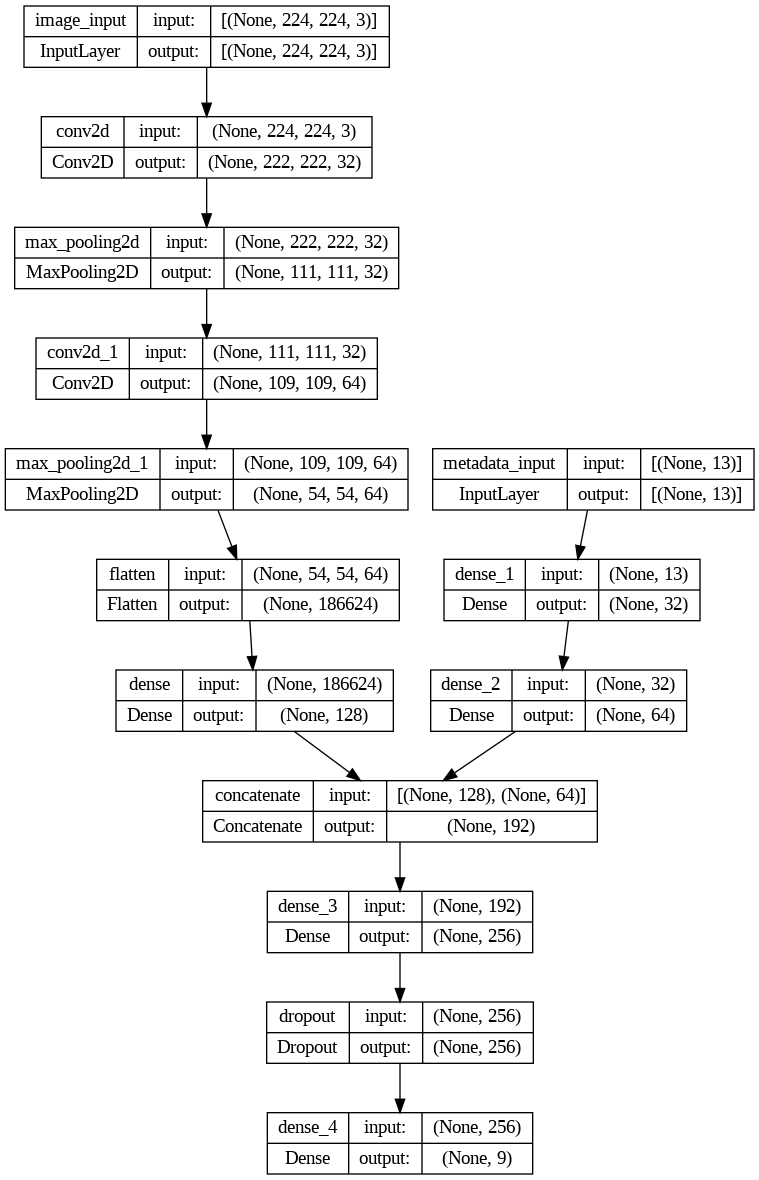

In [36]:
# Generate a plot of the model
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)


In [37]:
# Generate predictions using the test generator
predictions = model.predict(test_gen, steps=len(test_gen))

# Obtain the predicted classes by taking the argmax of the predictions array
predicted_classes = np.argmax(predictions, axis=1)

# Since your test_gen should also be outputting the true classes in the same order as the predictions:
# We need to collect all true classes from the generator (in the same order)
true_classes = []
for _, labels in test_gen:
    true_classes.extend(np.argmax(labels, axis=1))
    if len(true_classes) >= len(predictions):
        break  # Stop once we have all the labels we need

# Generate the confusion matrix
cm = confusion_matrix(true_classes[:len(predictions)], predicted_classes)

print(cm)


79/79 [==============================] - 35s 446ms/step
[[ 68 247  90   0  24   0   3   0]
 [164 777 277   4  59   0   2   0]
 [ 45 202  79   4  17   0   2   0]
 [ 12  55  24   0   6   0   0   0]
 [ 36 150  58   2  12   0   0   0]
 [  2  13   5   0   1   0   0   0]
 [  2  19   6   0   4   0   0   0]
 [  7  33  14   0   3   0   0   0]]


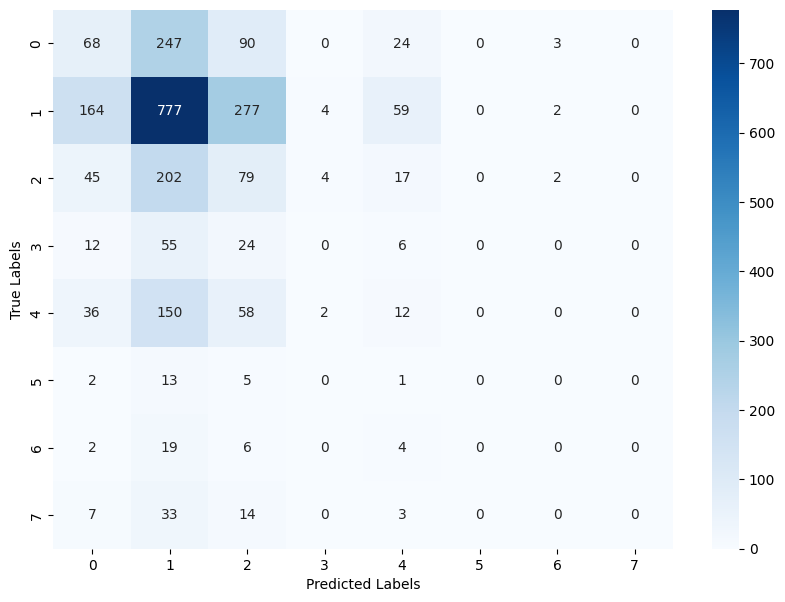

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

66.46% is ok, but lets do some fine tuning... and save it!

1/1 [==============================] - 0s 30ms/step
Confusion Matrix:
 [[ 195  162   55    0   20    0    0    0]
 [  55 1172   44    0   12    0    0    0]
 [  20   56  261    0   12    0    0    0]
 [  11    6   58    7   15    0    0    0]
 [  44   82   63    3   66    0    0    0]
 [   3    6   11    0    0    0    1    0]
 [   1    8   16    0    0    0    6    0]
 [   8    2   46    0    1    0    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.45      0.51       432
           1       0.78      0.91      0.84      1283
           2       0.47      0.75      0.58       349
           3       0.70      0.07      0.13        97
           4       0.52      0.26      0.34       258
           5       0.00      0.00      0.00        21
           6       0.86      0.19      0.32        31
           7       0.00      0.00      0.00        57

    accuracy                           0.68      2528
   macro avg     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


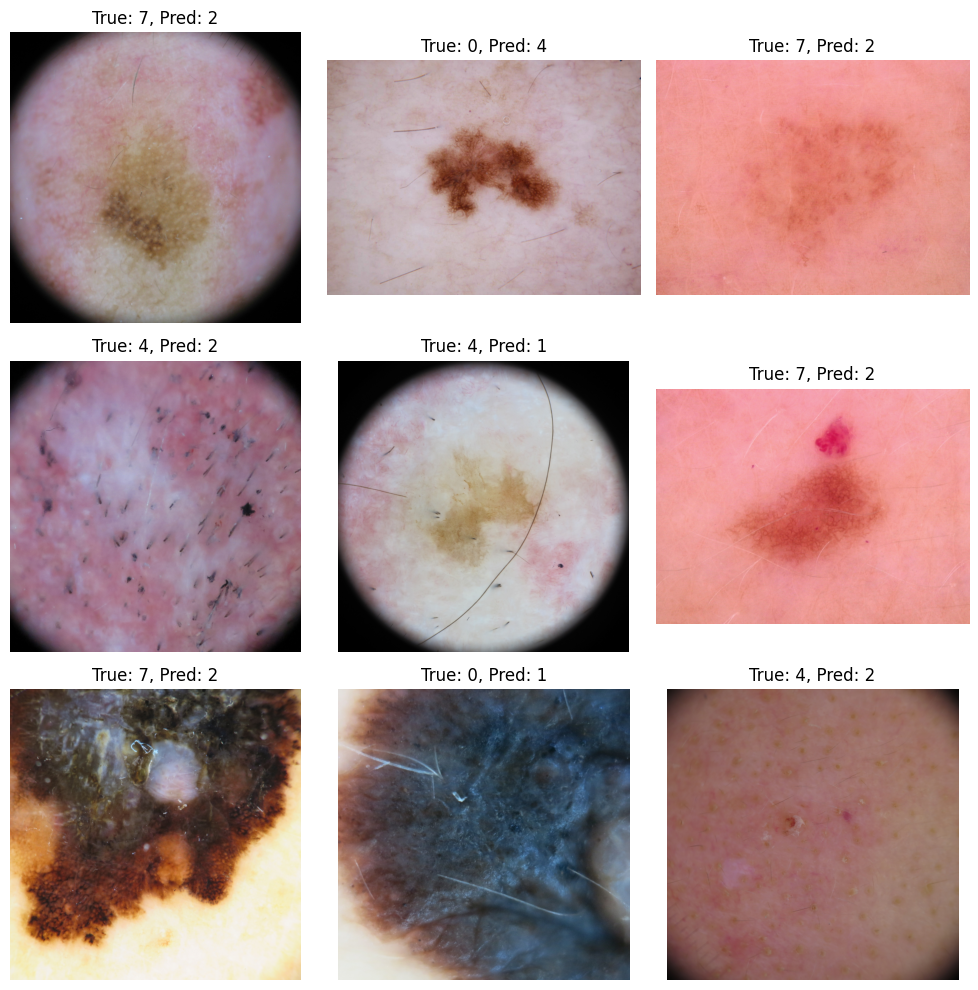

In [41]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load the model
model = load_model('/content/best_model.h5')

# Function to fetch data and labels from the generator
def get_predictions_and_labels(generator):
    predictions = []
    true_labels = []
    for _ in range(len(generator)):
        # Getting the next batch of data
        (images, metadata), labels = generator.__getitem__(_)
        # Predict this batch
        batch_predictions = model.predict([images, metadata])
        # Store predictions and labels
        predictions.append(batch_predictions)
        true_labels.append(labels)

    # Concatenate all batches
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)

    return predictions, true_labels

# Using the test generator to get predictions and labels
predictions, true_labels = get_predictions_and_labels(test_gen)

# Convert softmax probabilities to class predictions
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(true_labels, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:\n', cm)

# Generate a classification report
print('\nClassification Report:\n', classification_report(true_classes, predicted_classes))

# Identify misclassified examples
misclassified_indices = np.where(predicted_classes != true_classes)[0]
print(f'Total misclassified samples: {len(misclassified_indices)}')

# Assuming you want to visualize some misclassified images:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    if i < len(misclassified_indices):
        idx = misclassified_indices[i]
        img = test_gen.image_paths[idx]  # Assuming image paths are stored here
        true_label, pred_label = true_classes[idx], predicted_classes[idx]
        ax.imshow(plt.imread(img))  # Reading the image from path
        ax.set_title(f'True: {true_label}, Pred: {pred_label}')
        ax.axis('off')
plt.tight_layout()
plt.show()


In [69]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from datetime import datetime

# Load the previously saved model
model = load_model('/content/best_model.h5')

# Define your callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=1),
    ModelCheckpoint(filepath='/content/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Path where the checkpoint will be saved
model_dir = '/content/drive/My Drive/Colab Models'
# Generate a unique identifier based on the current date and time
unique_identifier = datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_filepath = os.path.join(model_dir, f'best_model_{unique_identifier}.h5')

# model_filename = 'best_model.h5'
# # Check if the best model exists and load it
# if os.path.exists(model_filename):
#     model = load_model(model_filename)
#     print("Loaded the best model from the last training session.")
# # Continue with defining callbacks without overwriting the best model inadvertently
# # callbacks = [
# #    ModelCheckpoint(filepath=model_filename, monitor='val_loss', save_best_only=True, verbose=1)]


# Continue training with generators and include callbacks
history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    # Adjust the total epochs as needed
    epochs=20,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=callbacks
)


Epoch 1/20
633/633 [==============================] - ETA: 0s - loss: 0.8097 - accuracy: 0.7104
Epoch 1: val_loss improved from inf to 0.93085, saving model to /content/best_model.h5
633/633 [==============================] - 326s 509ms/step - loss: 0.8097 - accuracy: 0.7104 - val_loss: 0.9308 - val_accuracy: 0.6610
Epoch 2/20
633/633 [==============================] - ETA: 0s - loss: 0.7814 - accuracy: 0.7224
Epoch 2: val_loss did not improve from 0.93085
633/633 [==============================] - 316s 499ms/step - loss: 0.7814 - accuracy: 0.7224 - val_loss: 0.9407 - val_accuracy: 0.6638
Epoch 3/20
633/633 [==============================] - ETA: 0s - loss: 0.7442 - accuracy: 0.7339
Epoch 3: val_loss improved from 0.93085 to 0.92508, saving model to /content/best_model.h5
633/633 [==============================] - 318s 502ms/step - loss: 0.7442 - accuracy: 0.7339 - val_loss: 0.9251 - val_accuracy: 0.6725
Epoch 4/20
633/633 [==============================] - ETA: 0s - loss: 0.7141 - acc

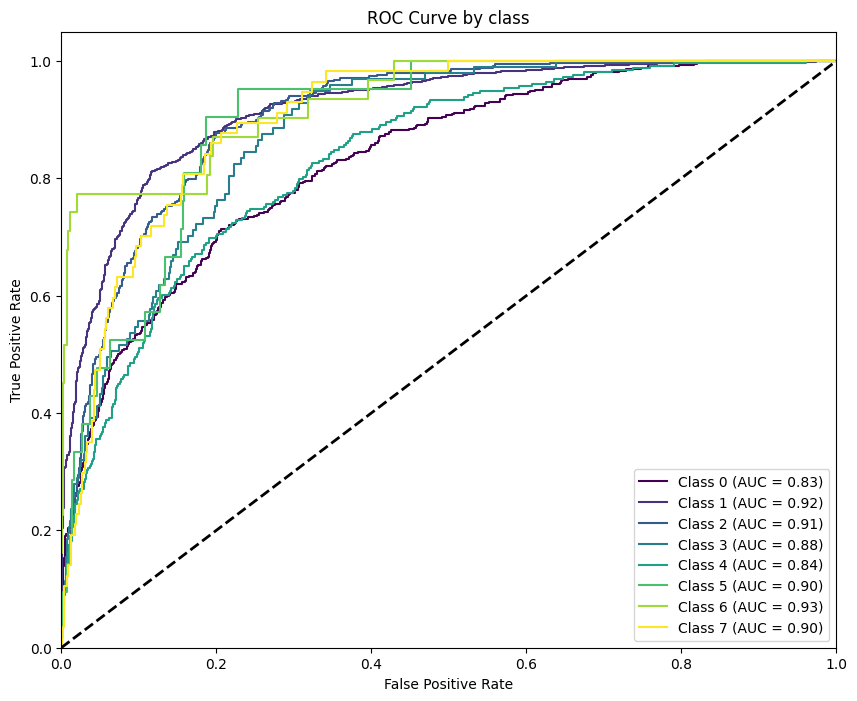

In [54]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Ensure that true_labels is a 1D array of class indices
if len(true_labels.shape) > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Ensure predictions are probabilities
if predictions.shape[1] == len(np.unique(true_labels)):
    print("Predictions appear to be properly formatted.")

n_classes = len(np.unique(true_labels))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    # Isolate the probabilities for the current class
    class_probs = predictions[:, i]
    # Create a binary outcome for this class
    class_true = (true_labels == i).astype(int)
    fpr[i], tpr[i], _ = roc_curve(class_true, class_probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, n_classes))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by class')
plt.legend(loc="lower right")
plt.show()



In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Step 5: User Interface (UI)
A simple web-based UI allows users to upload lesion images, input relevant metadata, and receive a prediction. We will use Gradio as learned in class for this model.

In [48]:
! pip install gradio --upgrade
! pip install gradio ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.7 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl siz

In [49]:
! pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 7.0 MB/s eta 0:00:00


In [50]:
import gradio as gr
import numpy as np
from PIL import Image
import os

import openai

In [51]:
with open('/content/drive/MyDrive/API AI OPEN.txt', 'r') as file:
    openai_api_key = file.read().strip()

In [52]:
openai.api_key = openai_api_key

ok, lets finish the workflow by making a prediction on the preprocessed image

In [61]:
diagnosis_descriptions = {
    'MEL': 'Melanoma: a serious form of skin cancer that begins in cells known as melanocytes.',
    'NV': 'Melanocytic nevus: a common type of skin growth that often appears as a small, dark brown spot.',
    'BCC': 'Basal cell carcinoma: a type of skin cancer that most often develops on areas exposed to the sun.',
    'AK': 'Actinic keratosis: a rough, scaly patch on the skin caused by years of sun exposure.',
    'BKL': 'Benign keratosis: a non-cancerous skin condition that appears as a waxy brown, black, or tan growth.',
    'DF': 'Dermatofibroma: a common growth on the skin, usually found on the lower legs, that can be pink, red, or brown.',
    'VASC': 'Vascular lesion: a type of abnormal growth or mark on the skin that is made up of blood vessels.',
    'SCC': 'Squamous cell carcinoma: a common form of skin cancer that develops in the squamous cells.',
    'UNK': 'None of the others: the lesion does not fit into any of the other categories.'
}

disclaimer = """
**Disclaimer:** This tool is intended for educational and entertainment purposes only and should not be used as a substitute for professional medical advice, diagnosis, or treatment. Always seek the advice of your physician or other qualified health provider with any questions you may have regarding a medical condition. Remember, this AI is not a medical doctor, and its assessments are not diagnoses. Use this tool responsibly and always consult with a healthcare professional for any medical concerns.
"""


In [70]:
import gradio as gr
from gradio import Image, Number, Radio, Dropdown
import numpy as np
from PIL import Image as PILImage
import openai
import tensorflow as tf
from tensorflow import keras

# Load the model
model_path = '/content/best_model.h5'
model = keras.models.load_model(model_path)

# Print model summary
model.summary()

# Create a dummy input array and make a prediction
test_input = np.random.random((1, 224, 224, 3))
test_prediction = model.predict(test_input)
print(test_prediction)

def preprocess_image(uploaded_image):
    img = PILImage.open(uploaded_image).resize((224, 224))  # Ensure uploaded_image is a path or file-like object
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_and_explain(image, age, sex, location):
    preprocessed_image = preprocess_image(image)
    # Replace the following line with your model prediction logic
    prediction = model.predict(preprocessed_image)[0]
    predicted_class_index = np.argmax(prediction)
    predicted_class_key = list(diagnosis_descriptions.keys())[predicted_class_index]
    description = diagnosis_descriptions[predicted_class_key]

    metadata_sentence = f"A {age}-year-old {sex} has a lesion located at {location}."

    try:
        response = openai.Completion.create(
            engine="text-davinci-003",
            prompt=f"{metadata_sentence} It was diagnosed as {predicted_class_key} ({description}). Provide an explanation.",
            temperature=0.7,
            max_tokens=100
        )
        additional_info = response.choices[0].text.strip()
    except Exception as e:
        additional_info = "Could not fetch additional information from GPT-3."

    full_explanation = f"Diagnosis: {predicted_class_key} - {description}.\n\nAdditional info: {additional_info}"
    return full_explanation

# Create the interface
iface = gr.Interface(
    fn=predict_and_explain,
    inputs=[
        Image(),  # Removed the shape parameter
        Number(label="Age"),
        Radio(choices=['Male', 'Female', 'Other'], label="Sex"),
        Dropdown(choices=['Head/Neck', 'Upper Extremity', 'Lower Extremity', 'Torso', 'Palms/Soles', 'Oral/Genital', 'Other'], label="Anatomical Site")
    ],
    outputs="text",
    title="Skin Lesion Classifier",
    description="Upload an image of a skin lesion and enter metadata to predict its type. Read the disclaimer below before proceeding."
)

# Launch the interface
iface.launch()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d[0][0]']   

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 224, 224, 3) dtype=float32>]
